<a href="https://colab.research.google.com/github/casanchez25/house_price_pediction/blob/main/GBoosting_and_NN_of_House_Prices_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from keras import layers, models, optimizers
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt

In [3]:
import os
import tensorflow as tf


# IMPORT AND READ

### Importing Datasets from kaggle*

Saving the kaggle json on Colab's main directory

In [11]:
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c house-prices-advanced-regression-techniques

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 68.3MB/s]


## READING DATASETS

In [14]:
###KAGGLE

df_train = pd.read_csv('/content/train.csv',encoding='utf-8')
df_test=pd.read_csv('/content/test.csv',encoding='utf-8')


In [15]:
class Mean_encoding():

  def __init__(self, data, var_cat, target_name):
    self.data = data
    self.var_cat = var_cat
    self.target_name = target_name


  def encode(data, var_cat = str, target_name = str):
    encoding_item_id=data.groupby([str(var_cat)])[[str(target_name)]].mean()
    encoding_item_id.rename(columns={str(target_name):'encoding_item'}, inplace=True)
    encoding_item_id['encoding_item'] = round(encoding_item_id['encoding_item'],2)
    data=data.join(encoding_item_id, on=[str(var_cat)])
    
    return data

  def decode(data, var_cat = str, target_name = str):
    encoding_item_id=data.groupby([str(var_cat)])[[str(target_name)]].mean()
    encoding_item_id.reset_index(inplace=True)
    encoding_item_id.rename(columns={str(target_name):'encoding_item'}, inplace=True)
    encoding_item_id['encoding_item'] = round(encoding_item_id['encoding_item'],2)
    encoding_item_id.reset_index(inplace=True)
    
    encoding_item_id.set_index(['encoding_item'], inplace=True)
    item_dict=encoding_item_id.to_dict()
    return item_dict

  def encode_dict(data, var_cat = str, target_name = str):
    encoding_item_id=data.groupby([str(var_cat)])[[str(target_name)]].mean()
    encoding_item_id.rename(columns={str(target_name): var_cat+'_code'}, inplace=True)
    encoding_item_id[var_cat+'_code'] = round(encoding_item_id[var_cat+'_code'],2)
    item_dict=encoding_item_id.to_dict()
    code_dict[var_cat+'_code']= item_dict[var_cat+'_code']
  
    return code_dict

# Data Analysis

In [17]:
df_train['Alley'].nunique()

2

In [18]:
df_train['Alley'].isnull().sum()

1369

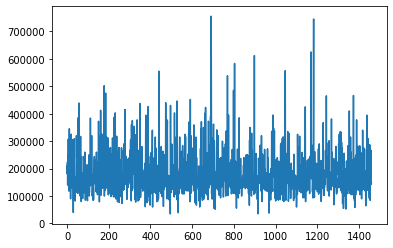

In [19]:
plt.plot(df_train['SalePrice'])

In [20]:
df_train.fillna(0, inplace=True)

In [21]:
#df_train=df_train[df_train['SalePrice']<300000]

In [22]:
#df_train=df_train[df_train['SalePrice']>80000]

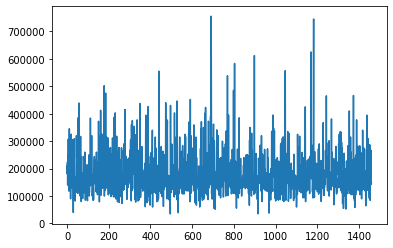

In [23]:
plt.plot(df_train['SalePrice'])

In [24]:
cols=df_train.columns.to_list()
cols.pop(0)
cols.pop(-1)

'SalePrice'

In [25]:
num_cols=df_train.describe().columns.to_list()

In [26]:
cat_cols=[]

In [27]:
for i in cols:
  if i not in num_cols:
    cat_cols.append(i)

In [28]:
cat_cols

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [29]:
code_dict={}

In [30]:
for i in cat_cols:
  df_encoding = Mean_encoding.encode(df_train, i, 'SalePrice')
  code_dict= Mean_encoding.encode_dict(df_encoding, i, 'SalePrice')
  #decode= Mean_encoding.decode(df_encoding,i, 'SalePrice')
  df_encoding.drop(columns=['SalePrice',i], inplace=True)
  df_train[i]=df_train[i].apply(lambda x: code_dict[i+'_code'].get(x))

Visualizing a heatmap to understand the correlation between features

In [31]:
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,191004.99,65.0,8450,181130.54,183452.13,164754.82,180183.75,180950.96,...,0,180404.66,187596.84,182046.41,0,2,2008,173401.84,175202.22,208500
1,2,20,191004.99,80.0,9600,181130.54,183452.13,164754.82,180183.75,180950.96,...,0,180404.66,187596.84,182046.41,0,5,2007,173401.84,175202.22,181500
2,3,60,191004.99,68.0,11250,181130.54,183452.13,206101.67,180183.75,180950.96,...,0,180404.66,187596.84,182046.41,0,9,2008,173401.84,175202.22,223500
3,4,70,191004.99,60.0,9550,181130.54,183452.13,206101.67,180183.75,180950.96,...,0,180404.66,187596.84,182046.41,0,2,2006,173401.84,146526.62,140000
4,5,60,191004.99,84.0,14260,181130.54,183452.13,206101.67,180183.75,180950.96,...,0,180404.66,187596.84,182046.41,0,12,2008,173401.84,175202.22,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,191004.99,62.0,7917,181130.54,183452.13,164754.82,180183.75,180950.96,...,0,180404.66,187596.84,182046.41,0,8,2007,173401.84,175202.22,175000
1456,1457,20,191004.99,85.0,13175,181130.54,183452.13,164754.82,180183.75,180950.96,...,0,180404.66,148751.09,182046.41,0,2,2010,173401.84,175202.22,210000
1457,1458,70,191004.99,66.0,9042,181130.54,183452.13,164754.82,180183.75,180950.96,...,0,180404.66,178927.46,151187.61,2500,5,2010,173401.84,175202.22,266500
1458,1459,20,191004.99,68.0,9717,181130.54,183452.13,164754.82,180183.75,180950.96,...,0,180404.66,187596.84,182046.41,0,4,2010,173401.84,175202.22,142125


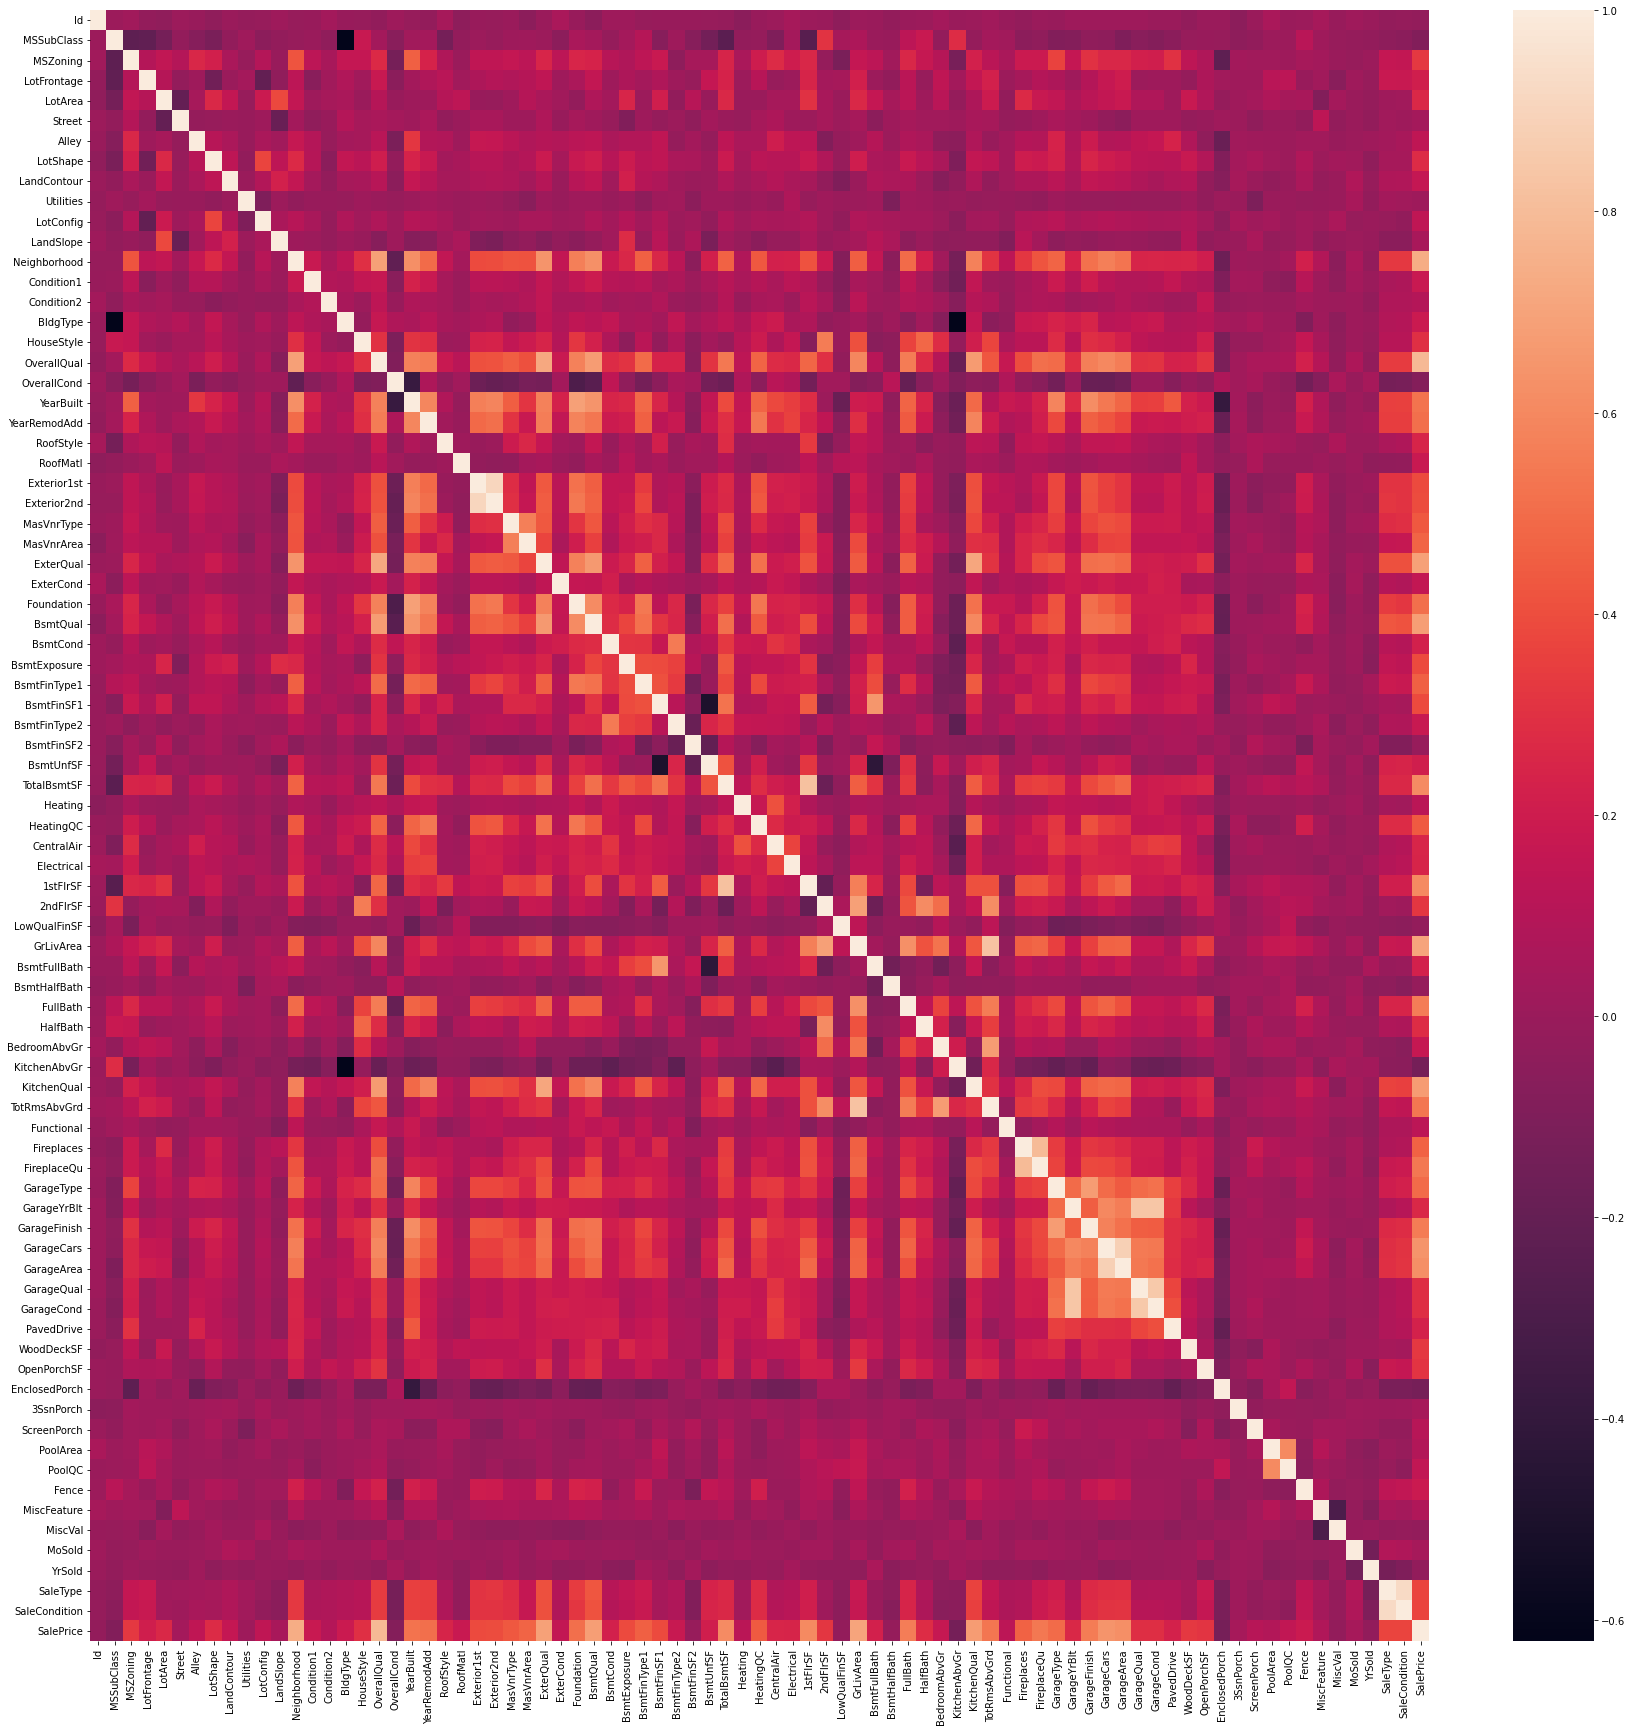

In [32]:
plt.figure(figsize=(30,30))
sns.heatmap(df_train.corr())

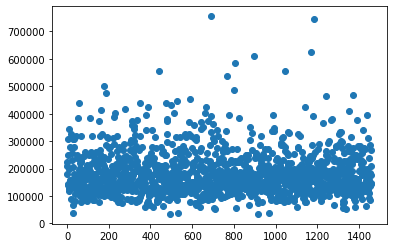

In [33]:
plt.scatter(df_train.index,df_train['SalePrice'])

# Splitting

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
data_train, val_data, train_labels, val_labels = train_test_split(df_train.drop(columns=['SalePrice']),df_train['SalePrice'], 
                                                                 test_size=.3, random_state=42)

In [36]:
train_data_mean = data_train.mean()
train_data_std = data_train.std()

train_labels_mean = train_labels.mean()
train_labels_std = train_labels.std()

data_train = (data_train - train_data_mean)/ train_data_std
train_labels = (train_labels - train_labels_mean)/ train_labels_std

val_data = (val_data - train_data_mean)/ train_data_std
val_labels = (val_labels - train_labels_mean)/ train_labels_std

Splitting val and test

In [37]:
test_data = val_data[int(val_data['Id'].count()*.5):]
val_data =val_data[:int(val_data['Id'].count()*.5)]

test_labels = val_labels[int(val_labels.count()*.5):]
val_labels =val_labels[:int(val_labels.count()*.5)]

In [38]:
##DATA
data_train = data_train.to_numpy()
val_data = val_data.to_numpy()
test_data = test_data.to_numpy()
##LABELS
train_labels = train_labels.to_numpy()
val_labels = val_labels.to_numpy()
test_labels = test_labels.to_numpy()



In [39]:
print('train data shape',data_train.shape)
print('val data shape',val_data.shape)
print('test data shape',test_data.shape)
print('train labels shape',train_labels.shape)
print('val_labels_shape',val_labels.shape)
print('test_labels_shape',test_labels.shape)

train data shape (1022, 80)
val data shape (219, 80)
test data shape (219, 80)
train labels shape (1022,)
val_labels_shape (219,)
test_labels_shape (219,)


In [40]:
data_train[1].shape

(80,)

# Modeling

In [41]:
import tensorflow as tf


In [42]:
lr_var = 0.0001

model = models.Sequential()
model.add(layers.Dense(200, activation='sigmoid', input_shape=(data_train[1].shape)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(200, activation='sigmoid'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_var), loss='mse', metrics=['mae']) 


In [43]:
history= model.fit(data_train, train_labels,
                     epochs= 50,
                     batch_size=25,
                     validation_data=(val_data, val_labels))



Epoch 1/50
41/41 [==============================] - 1s 7ms/step - loss: 1.5084 - mae: 0.9320 - val_loss: 1.2020 - val_mae: 0.7568
Epoch 2/50
41/41 [==============================] - 0s 4ms/step - loss: 1.4280 - mae: 0.9112 - val_loss: 1.0458 - val_mae: 0.6883
Epoch 3/50
41/41 [==============================] - 0s 3ms/step - loss: 1.2669 - mae: 0.8462 - val_loss: 0.9077 - val_mae: 0.6228
Epoch 4/50
41/41 [==============================] - 0s 3ms/step - loss: 1.1722 - mae: 0.8189 - val_loss: 0.7799 - val_mae: 0.5607
Epoch 5/50
41/41 [==============================] - 0s 4ms/step - loss: 0.9873 - mae: 0.7560 - val_loss: 0.6827 - val_mae: 0.4925
Epoch 6/50
41/41 [==============================] - 0s 3ms/step - loss: 0.9570 - mae: 0.7419 - val_loss: 0.5915 - val_mae: 0.4469
Epoch 7/50
41/41 [==============================] - 0s 3ms/step - loss: 0.8776 - mae: 0.7009 - val_loss: 0.5264 - val_mae: 0.4323
Epoch 8/50
41/41 [==============================] - 0s 3ms/step - loss: 0.8168 - mae: 0.66

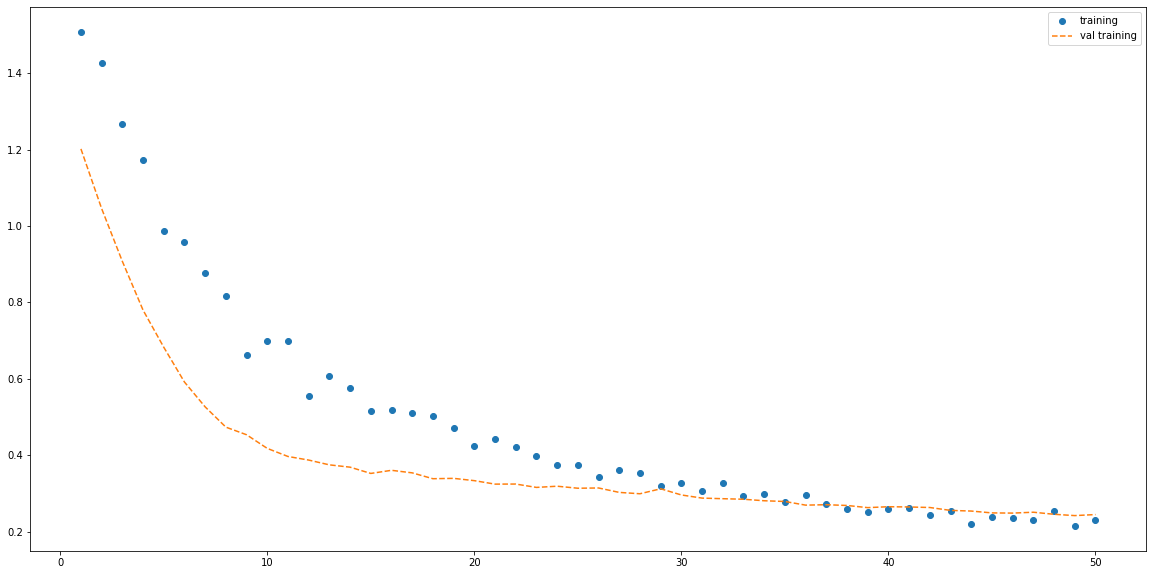

In [44]:
history_dict = history.history
#estamos guardando la informacion que habia de history en diccionario
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values)+1)
plt.figure(figsize=(20,10))
plt.plot(epochs, loss_values, 'o', label='training')
plt.plot(epochs, val_loss_values,'--', label='val training')
plt.legend()
plt.show()

# Testing and Predicting

In [45]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [46]:
def predictions(val_data, val_labels, xmin=False, xmax=False): 
  predictions_norm =model.predict(val_data)
  predictions = predictions_norm * train_labels_std + train_labels_mean
  comparacion=pd.DataFrame(predictions, columns=['predictions'])

  
  val_labels_real = val_labels*train_labels_std+train_labels_mean
  target= pd.DataFrame(val_labels_real, columns=['target'])
  target.reset_index(inplace=True)
  comparacion['target']=target['target']
  comparacion

  #PLOTTING
  plt.figure(figsize=(20,10))
  plt.scatter(comparacion.index,comparacion['predictions'], c='blue', label='predictions')
  
  
  plt.scatter(comparacion.index,comparacion['target'], c='orange', label='target')
  
  if xmin | xmax:
    plt.xlim(xmin,xmax)
  plt.legend()
  plt.show()

  #MAE SCORE
  
  print('mean_absolute_error',mean_absolute_error(val_labels, predictions_norm))
  print('mean_squared_error',mean_squared_error(val_labels, predictions_norm))


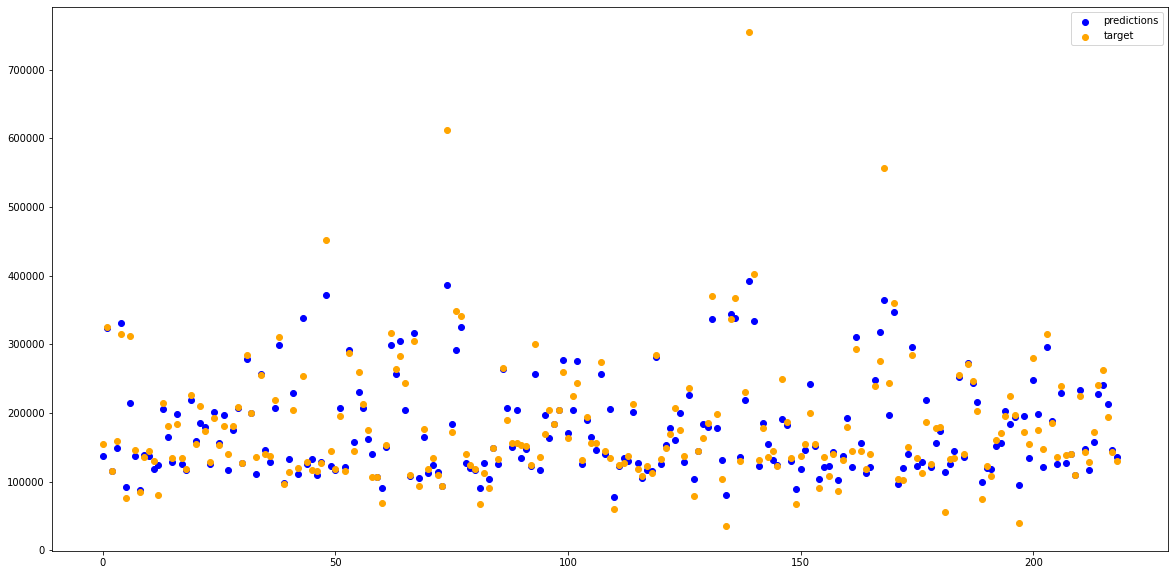

mean_absolute_error 0.23747445260323807
mean_squared_error 0.24447641386158547


In [47]:
predictions(val_data, val_labels)

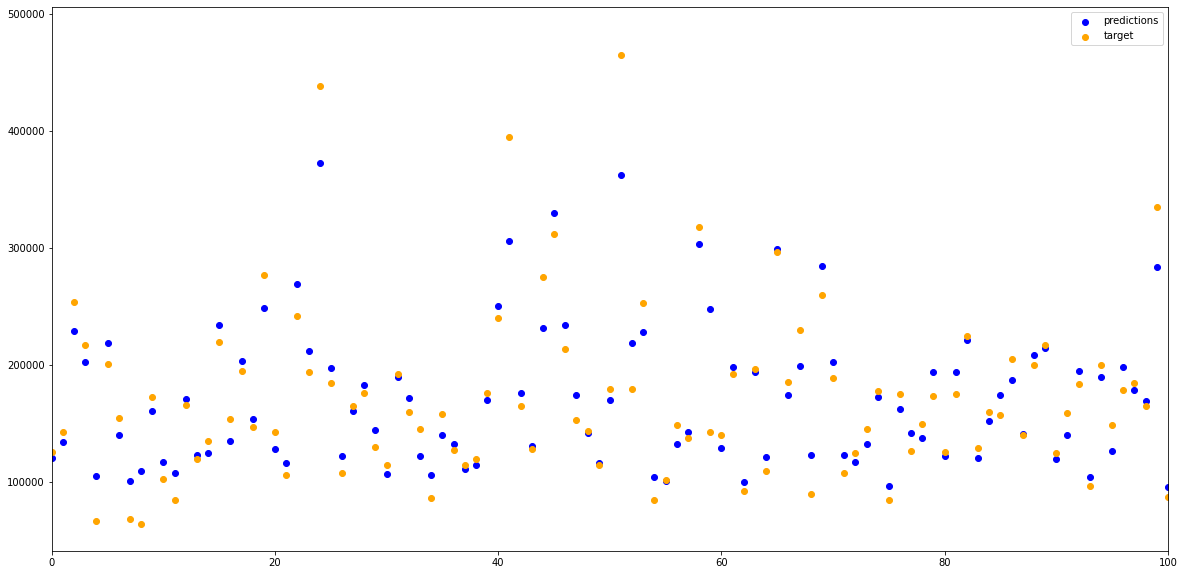

mean_absolute_error 0.21501694249404085
mean_squared_error 0.10156758497428939


In [48]:
predictions(test_data,test_labels,0,100)

# GRADIENT BOOSTING REGRESSOR

In [49]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

params = {'loss':['huber','squared_error','absolute_error'],
          'learning_rate' : np.linspace(0.01,0.1,num=10),
          'n_estimators':range(100,350),
          'alpha':np.linspace(0.9,0.99, num=10),
          'max_depth': range(3,5),
          #'min_weight_fraction_leaf':np.linspace(0,1,num=10)
          }
    

boost =GradientBoostingRegressor()

rand_est = RandomizedSearchCV(boost, params, n_iter=10, cv=3, scoring='neg_mean_absolute_error').fit(data_train, train_labels)

print(rand_est.best_estimator_)


GradientBoostingRegressor(alpha=0.99, learning_rate=0.07, loss='absolute_error',
                          max_depth=4, n_estimators=216)


In [50]:
rand_est.best_params_

{'alpha': 0.99,
 'learning_rate': 0.07,
 'loss': 'absolute_error',
 'max_depth': 4,
 'n_estimators': 216}

In [51]:
rand_est.best_score_

-0.20878669596467012

In [52]:
def boost_predictions(val_data, val_labels, xmin=False, xmax=False): 
  predictions_norm =rand_est.predict(val_data)
  predictions = predictions_norm * train_labels_std + train_labels_mean
  comparacion=pd.DataFrame(predictions, columns=['predictions'])

  
  val_labels_real = val_labels*train_labels_std+train_labels_mean
  target= pd.DataFrame(val_labels_real, columns=['target'])
  target.reset_index(inplace=True)
  comparacion['target']=target['target']
  comparacion

  #PLOTTING
  plt.figure(figsize=(20,10))
  plt.scatter(comparacion.index,comparacion['predictions'], c='blue', label='predictions')
  
  
  plt.scatter(comparacion.index,comparacion['target'], c='orange', label='target')
  
  if xmin | xmax:
    plt.xlim(xmin,xmax)
  plt.legend()
  plt.show()

  #MAE SCORE
  
  print('mean_absolute_error',mean_absolute_error(val_labels, predictions_norm))
  print('mean_squared_error',mean_squared_error(val_labels, predictions_norm))


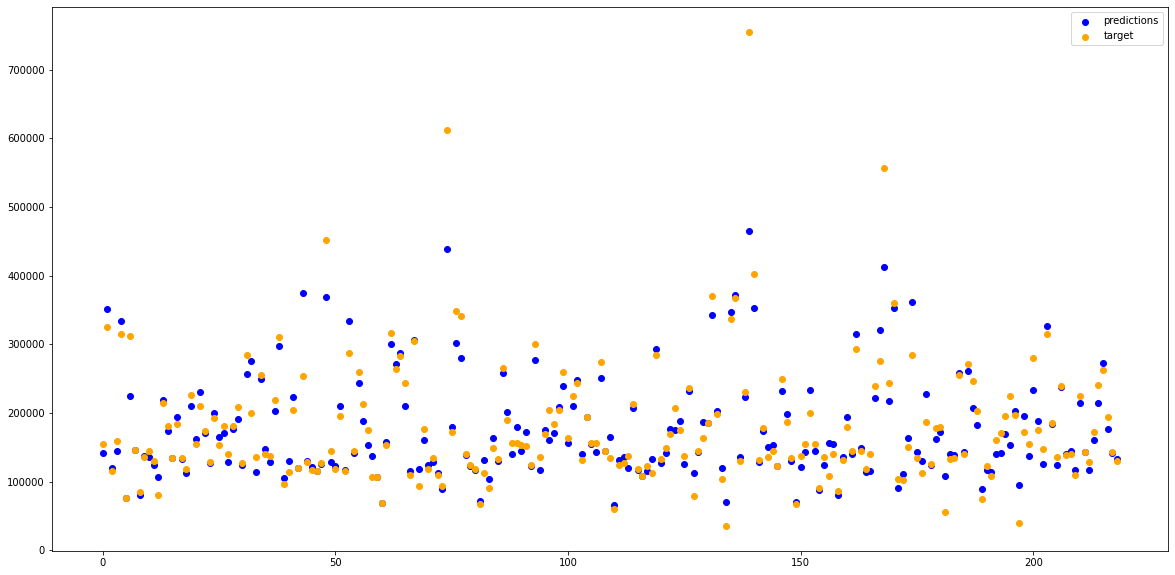

mean_absolute_error 0.22395988613436482
mean_squared_error 0.185451093484586


In [53]:
boost_predictions(val_data, val_labels)

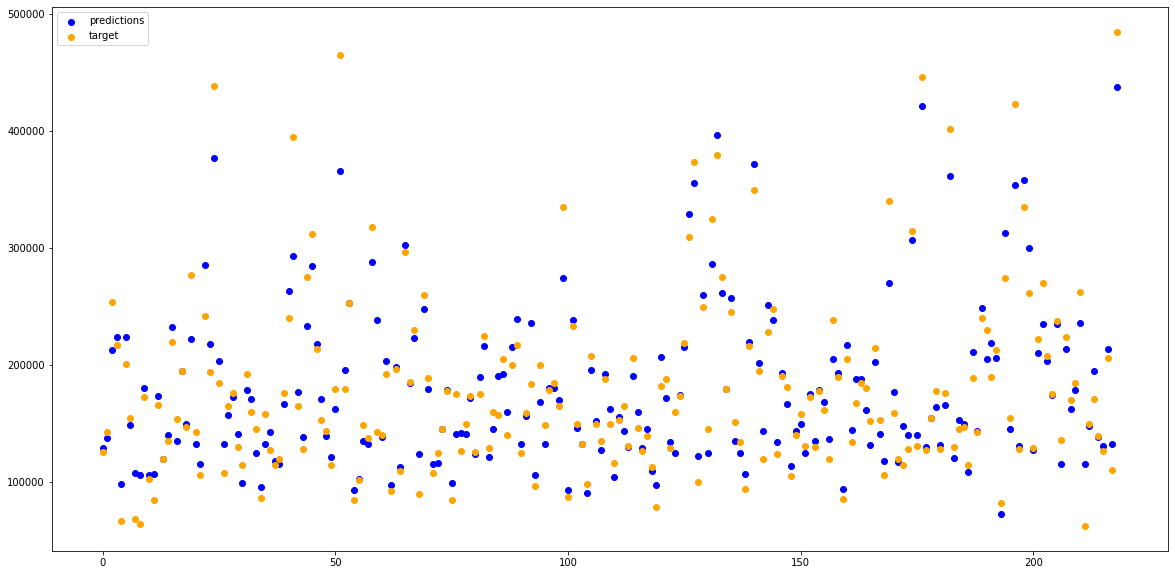

mean_absolute_error 0.19899503245248787
mean_squared_error 0.0853226294338054


In [54]:
boost_predictions(test_data, test_labels)

# KAGGLE PREDICTIONS

In [55]:
df_test=pd.read_csv('/content/test.csv')

In [56]:
df_test.fillna(0, inplace=True)

In [57]:
for i in cat_cols:
   df_test[i]=df_test[i].apply(lambda x: code_dict[i+'_code'].get(x))


In [58]:
#df_test=df_test[['Id']+corr_cols[:-1]]

In [59]:
testings=(df_test-train_data_mean)/train_data_std

In [60]:
testings.fillna(0, inplace=True)

In [61]:
testings = np.array(testings)

In [62]:
submit=rand_est.predict(testings)

In [63]:
nn = model.predict(testings)
nn = pd.DataFrame(nn, columns=['Neuronal'])
nn = nn*train_labels_std+train_labels_mean

In [64]:
submit = pd.DataFrame(submit, columns=['SalePrice'])

In [65]:
submit = submit*train_labels_std+train_labels_mean

In [66]:
submit['Neuronal']=nn['Neuronal']

In [67]:
submit

,SalePrice,Neuronal
0,127311.795894,116192.835938
1,156416.613160,161749.828125
2,188153.426258,177056.718750
3,199341.821861,197048.609375
4,200126.607103,185170.546875
...,...,...
1454,88954.612770,92757.187500
1455,88832.964329,99054.414062
1456,178167.773695,170682.187500
1457,126932.552110,111008.734375


In [68]:
submit['Id']=df_test['Id']

In [69]:
submit=submit[['Id','SalePrice','Neuronal']]

In [70]:
#submit.to_csv(r'/content/drive/My Drive/kaggle datasets/submit.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81f16cd810>,
      dtype=object)

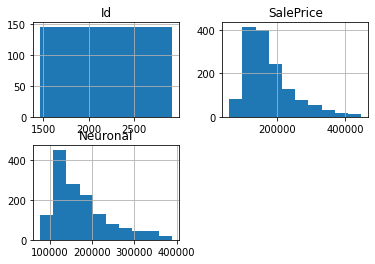

In [71]:
submit.hist()